In [1]:
setwd('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.5_Baseline Cluster Analyses/Eigencytokine Input')
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.5_Baseline Cluster Analyses/Eigencytokine Output')
cur_date = "030821"

library(readxl)
library(plyr)
library(dplyr)
library(tidyverse)
library(janitor)
#library(ltm)
require(foreign)
require(nnet)
require(ggplot2)
require(reshape2)
#library(effects)
library(missForest)
library(tidyr)
#library(htmlwidgets)

#reading in file
cytokines <- data.frame(read_excel("CytokineData_102920.xlsx", sheet = 2))

#reading in demographics file
subjectinfo = data.frame(read_excel("SubjectInfo_102920.xlsx", sheet = 2))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.1
✔ readr   1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::r

First calculating baseline eigencytokines.

In [2]:
#upload cytokine data for each compartment 
ELF_cyto <- read.csv("011921ELF_NonNorm.csv")
NLF_cyto <- read.csv("011921NLF_NonNorm.csv")
Serum_cyto <- read.csv("011921Serum_NonNorm.csv")
Sputum_cyto <- read.csv("011921Sputum_NonNorm.csv")

#transpose cytokine data for each compartment
ELF_cyto <- as.data.frame(t(ELF_cyto)) %>% 
  row_to_names(row_number = 1)
NLF_cyto <- as.data.frame(t(NLF_cyto)) %>% 
  row_to_names(row_number = 1)
Serum_cyto <- as.data.frame(t(Serum_cyto)) %>% 
  row_to_names(row_number = 1)
Sputum_cyto <- as.data.frame(t(Sputum_cyto)) %>% 
  row_to_names(row_number = 1)

#cluster assignments for each compartment 
ELF_clus <- data.frame(read_excel("011921ELF_cluster_assignments.xlsx")) 
NLF_clus <- data.frame(read_excel("011921NLF_cluster_assignments.xlsx"))
Serum_clus <- data.frame(read_excel("011921Serum_cluster_assignments.xlsx"))
Sputum_clus <- data.frame(read_excel("011921Sputum_cluster_assignments.xlsx"))

#reading in scaled data
ELF_cyto_scaled <- read.csv("011921ELF_Scaled.csv")
NLF_cyto_scaled <- read.csv("011921NLF_Scaled.csv")
Serum_cyto_scaled <- read.csv("011921Serum_Scaled.csv")
Sputum_cyto_scaled <- read.csv("011921Sputum_Scaled.csv")

In [3]:
#renaming first column, grouping and splitting by "Cluster" column
ELF_clus <- ELF_clus %>%
  group_by(Cluster) %>% 
  group_split
NLF_clus <- NLF_clus %>%
  group_by(Cluster) %>% 
  group_split
Serum_clus <- Serum_clus %>% 
  group_by(Cluster) %>% 
  group_split
Sputum_clus <- Sputum_clus %>% 
  group_by(Cluster) %>% 
  group_split

#making dfs for each cluster for PCA analysis 
ELF_1 <- ELF_clus[[1]]
ELF_2 <- ELF_clus[[2]]
ELF_3 <- ELF_clus[[3]]

NLF_1 <- NLF_clus[[1]]
NLF_2 <- NLF_clus[[2]]
NLF_3 <- NLF_clus[[3]]

Serum_1 <- Serum_clus[[1]]
Serum_2 <- Serum_clus[[2]]
Serum_3 <- Serum_clus[[3]]

Sputum_1 <- Sputum_clus[[1]]
Sputum_2 <- Sputum_clus[[2]]
Sputum_3 <- Sputum_clus[[3]]

#making df with subjects' cytokine concentration data for each cluster 
ELF_1 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
ELF_2 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
ELF_3 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

NLF_1 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
NLF_2 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
NLF_3 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

Serum_1 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Serum_2 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Serum_3 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

Sputum_1 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Sputum_2 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Sputum_3 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

In [4]:
#PCA on each cluster, eigenvectors are in rotation -- PROBLEM - for some reason had to convert everything to numeric  
pca_ELF_1 <- ELF_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_ELF_2 <- ELF_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_ELF_3 <- ELF_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>%   
  prcomp()

pca_NLF_1 <- NLF_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_NLF_2 <- NLF_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_NLF_3 <- NLF_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

pca_Serum_1 <- Serum_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Serum_2 <- Serum_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Serum_3 <- Serum_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

pca_Sputum_1 <- Sputum_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Sputum_2 <- Sputum_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Sputum_3 <- Sputum_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

#eigenvector dfs of first principal component 
eigencytokines_ELF_1 <- data.frame(pca_ELF_1$rotation[,"PC1"])
  colnames(eigencytokines_ELF_1)[1] <- "ClusterA"
eigencytokines_ELF_2 <- data.frame(pca_ELF_2$rotation[,"PC1"])
  colnames(eigencytokines_ELF_2)[1] <- "ClusterB"
eigencytokines_ELF_3 <- data.frame(pca_ELF_3$rotation[,"PC1"])
  colnames(eigencytokines_ELF_3)[1] <- "ClusterC"

eigencytokines_NLF_1 <- data.frame(pca_NLF_1$rotation[,"PC1"])
  colnames(eigencytokines_NLF_1)[1] <- "ClusterA"
eigencytokines_NLF_2 <- data.frame(pca_NLF_2$rotation[,"PC1"])
  colnames(eigencytokines_NLF_2)[1] <- "ClusterB"
eigencytokines_NLF_3 <- data.frame(pca_NLF_3$rotation[,"PC1"])
  colnames(eigencytokines_NLF_3)[1] <- "ClusterC"
  
eigencytokines_Serum_1 <- data.frame(pca_Serum_1$rotation[,"PC1"])
  colnames(eigencytokines_Serum_1)[1] <- "ClusterA"
eigencytokines_Serum_2 <- data.frame(pca_Serum_2$rotation[,"PC1"])
  colnames(eigencytokines_Serum_2)[1] <- "ClusterB"
eigencytokines_Serum_3 <- data.frame(pca_Serum_3$rotation[,"PC1"])
  colnames(eigencytokines_Serum_3)[1] <- "ClusterC"

eigencytokines_Sputum_1 <- data.frame(pca_Sputum_1$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_1)[1] <- "ClusterA"
eigencytokines_Sputum_2 <- data.frame(pca_Sputum_2$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_2)[1] <- "ClusterB"
eigencytokines_Sputum_3 <- data.frame(pca_Sputum_3$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_3)[1] <- "ClusterC"
  

#collapse all eigencytokine dfs
eigencytokines_ELF <- cbind(eigencytokines_ELF_1, eigencytokines_ELF_2, eigencytokines_ELF_3)
eigencytokines_NLF <- cbind(eigencytokines_NLF_1, eigencytokines_NLF_2, eigencytokines_NLF_3)
eigencytokines_Serum <- cbind(eigencytokines_Serum_1, eigencytokines_Serum_2, eigencytokines_Serum_3)
eigencytokines_Sputum <- cbind(eigencytokines_Sputum_1, eigencytokines_Sputum_2, eigencytokines_Sputum_3)

#scale all eigencytokine dfs
eigencytokines_ELF_scaled <- as.data.frame(scale(eigencytokines_ELF))
eigencytokines_NLF_scaled <- as.data.frame(scale(eigencytokines_NLF))
eigencytokines_Serum_scaled <- as.data.frame(scale(eigencytokines_Serum))
eigencytokines_Sputum_scaled <- as.data.frame(scale(eigencytokines_Sputum))

In [14]:
#export all eigencytokine dfs
write.csv(eigencytokines_ELF, paste0(Output,"/", "eigencytokines_ELF.csv"), row.names=TRUE)
write.csv(eigencytokines_NLF, paste0(Output,"/", "eigencytokines_NLF.csv"), row.names=TRUE)
write.csv(eigencytokines_Serum, paste0(Output,"/", "eigencytokines_Serum.csv"), row.names=TRUE)
write.csv(eigencytokines_Sputum, paste0(Output,"/", "eigencytokines_Sputum.csv"), row.names=TRUE)

write.csv(eigencytokines_ELF_scaled, paste0(Output,"/", "eigencytokines_ELF_scaled.csv"), row.names=TRUE)
write.csv(eigencytokines_NLF_scaled, paste0(Output,"/", "eigencytokines_NLF_scaled.csv"), row.names=TRUE)
write.csv(eigencytokines_Serum_scaled, paste0(Output,"/", "eigencytokines_Serum_scaled.csv"), row.names=TRUE)
write.csv(eigencytokines_Sputum_scaled, paste0(Output,"/", "eigencytokines_Sputum_scaled.csv"), row.names=TRUE)

Now that the eigencytokines have been obtained, NLF Cluster A needs to be separated out. 

In [5]:
names(NLF_cyto_scaled)[1] = 'SubjectID'
eigencytokines_NLF_scaled = eigencytokines_NLF_scaled %>% #converting row names to cols
    rownames_to_column(var = 'SubjectID')
NLF_df = full_join(NLF_cyto_scaled,eigencytokines_NLF_scaled)
#NLF_df$Analysis = rep('Baseline', times = length(NLF_df$SubjectID)) #adding col to specify baseline or male only eigencytokines
head(NLF_df)

Joining, by = "SubjectID"



,SubjectID,Eotaxin,Eotaxin3,Fractalkine,IFNg,IL10,IL12p70,IL13,IL17B,IL17D,⋯,ITAC,MCP1,MIG,MIP1a,MIP1b,TARC,TNFa,ClusterA,ClusterB,ClusterC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NS_1,-0.5630023,-0.4805081,0.6681523,-0.5658910,-0.4260711,-0.8556839,0.6396792,-0.36710910,1.2349944,⋯,0.54007928,0.9936539,1.0919614,-0.7371228,-0.66788368,-0.4377484,0.77256144,1.12396338,0.9437515,1.1135789
2,NS_10,1.2478897,1.3468201,0.9244682,-0.4538609,-0.4448040,-0.1679861,-0.2004044,0.73336772,0.1071045,⋯,-0.40266259,0.8703994,-0.2025715,1.0662956,0.54592172,0.6105605,0.09613807,-0.06250489,-0.3364371,-0.5726643
3,NS_11,-0.7282788,-0.1330557,-1.4374693,-0.5760338,-0.7368060,-0.8556839,-0.6728642,0.19905648,-0.9462910,⋯,-1.17556020,-1.6267736,-0.9085956,0.5278317,-0.60990041,-1.4041857,-0.87437554,-1.35690710,-0.3323437,0.6831927
4,NS_12,0.2345743,-0.9425648,0.6237986,0.4574383,0.2951032,-0.8556839,1.7114512,0.36290325,-0.9462910,⋯,-0.06783334,-0.4230925,-0.6639902,-0.0413928,0.01950975,0.3642943,1.63936190,-0.05830437,-0.9919955,-0.1722885
5,NS_13,0.8426756,0.9207279,0.6106723,0.4395231,0.1961496,0.3127131,1.1794078,0.09373333,1.8859341,⋯,1.41419945,0.7520983,1.2282097,-0.1673460,-0.07109781,1.1577067,0.49321311,1.30214930,0.5735821,0.7535756
6,NS_14,0.6561918,-0.2125826,0.3720205,0.2925256,1.0040754,0.7873924,1.2207548,-0.51683698,2.0273798,⋯,1.20029363,0.3661717,1.9264547,0.1590909,0.30538560,-0.3759048,0.77134019,2.43725447,1.7259195,1.1515757


In [7]:
#getting descending subject ids based on average concentration of each subject id
ClusterA_ids = melt(NLF_df, variable = "Cytokine", value.name = "Conc") %>%
    filter(Cytokine %in% c("IFNg", "IL13", "IL10", "IL12p70", "IL17D", "IL4", "IL6", "TNFa")) %>%
    group_by(SubjectID) %>%
    summarize(Avg_Cytokine_Conc = mean(Conc)) %>%
    arrange(-Avg_Cytokine_Conc) %>%
    select(SubjectID) 
descending_subject_ids_ClusterA = as.vector(ClusterA_ids$SubjectID)

ClusterB_ids = melt(NLF_df, variable = "Cytokine", value.name = "Conc") %>%
    filter(Cytokine %in% c("Eotaxin", "Eotaxin3", "IL17B", "IL1b", "ITAC", "MCP1", "MIP1a", "MIP1b", "TARC")) %>%
    group_by(SubjectID) %>%
    summarize(Avg_Cytokine_Conc = mean(Conc)) %>%
    arrange(-Avg_Cytokine_Conc) %>%
    select(SubjectID) 
descending_subject_ids_ClusterB = as.vector(ClusterB_ids$SubjectID)

ClusterC_ids = melt(NLF_df, variable = "Cytokine", value.name = "Conc") %>%
    filter(Cytokine %in% c("MIG", "IL8", "IP10", "Fractalkine")) %>%
    group_by(SubjectID) %>%
    summarize(Avg_Cytokine_Conc = mean(Conc)) %>%
    arrange(-Avg_Cytokine_Conc) %>%
    select(SubjectID) 
descending_subject_ids_ClusterC = as.vector(ClusterC_ids$SubjectID)

Using SubjectID as id variables

Using SubjectID as id variables

Using SubjectID as id variables



# 2-D Visualization of Eigenvector (Figure 4)

Plots first principal components of eigencytokine in subjects of interest.

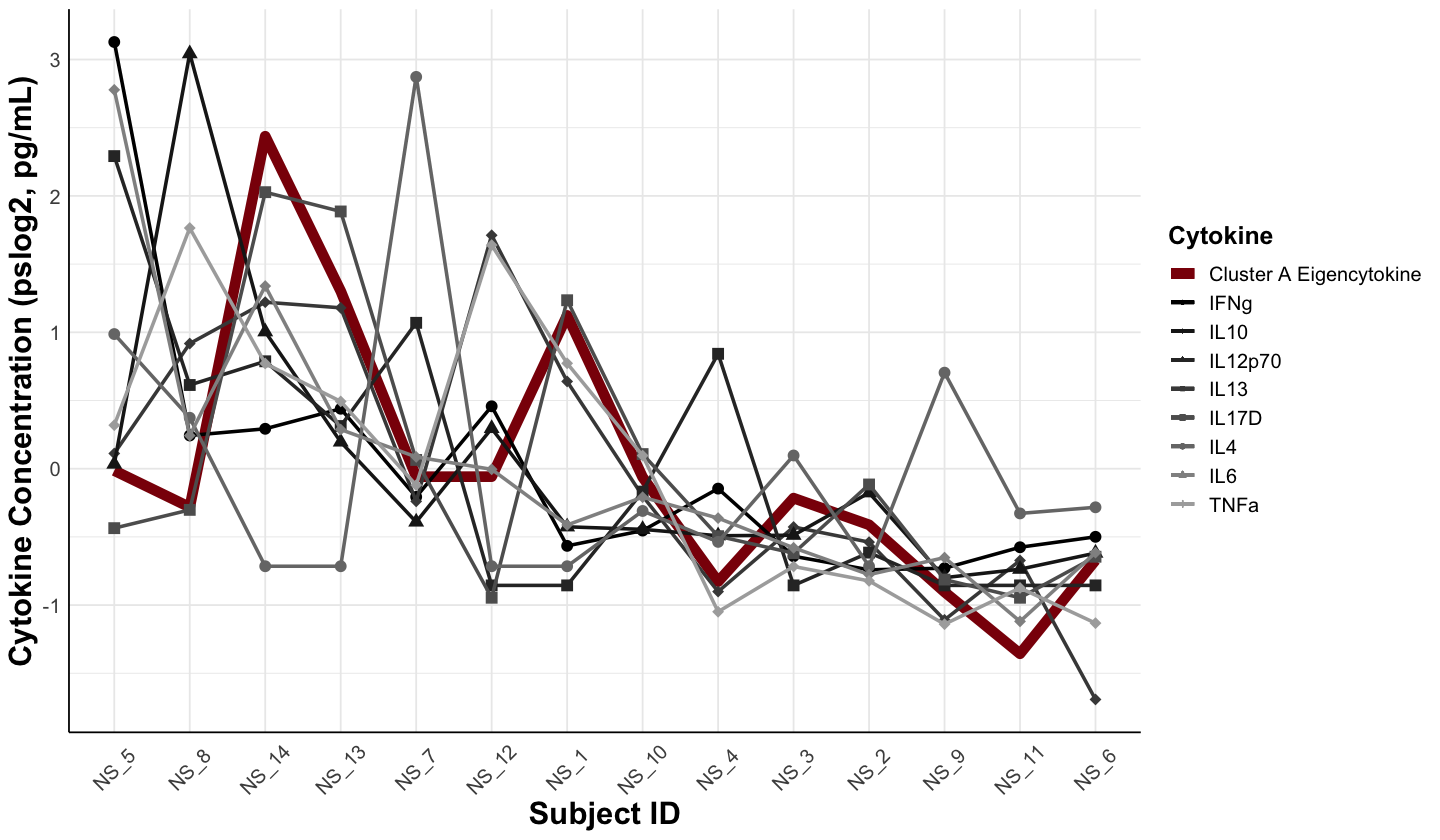

In [8]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
subject_ids = factor(NLF_df$SubjectID, levels = descending_subject_ids_ClusterA) #need to put descending_cytokines into a factor for plotting 
Figure4_A = ggplot(data = NLF_df, aes(x = subject_ids, y = value, color = variable, group = 1)) + 
  geom_line(aes(y = ClusterA, col = "Cluster A Eigencytokine"), size = 3) + 
  geom_line(aes(y = IFNg, col = "IFNg"), size = 1) + 
  geom_point(aes(y = IFNg, col = "IFNg"), shape = 16, size = 3) +
  geom_line(aes(y = IL13, col = "IL13"), size = 1) + 
  geom_point(aes(y = IL13, col = "IL13"), shape = 18, size = 3) +
  geom_line(aes(y = IL10, col = "IL10"), size = 1) + 
  geom_point(aes(y = IL10, col = "IL10"), shape = 17, size = 3) +
  geom_line(aes(y = IL12p70, col = "IL12p70"), size = 1) + 
  geom_point(aes(y = IL12p70, col = "IL12p70"), shape = 15, size = 3) +
  geom_line(aes(y = IL17D, col = "IL17D"), size = 1) + 
  geom_point(aes(y = IL17D, col = "IL17D"), shape = 15, size = 3) +
  geom_line(aes(y = IL4, col = "IL4"), size = 1) + 
  geom_point(aes(y = IL4, col = "IL4"), shape = 16, size = 3) +
  geom_line(aes(y = IL6, col = "IL6"), size = 1) + 
  geom_point(aes(y = IL6, col = "IL6"), shape = 18, size = 3) +
  geom_line(aes(y = TNFa, col = "TNFa"), size = 1) + 
  geom_point(aes(y = TNFa, col = "TNFa"), shape = 18, size = 3) +

  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12)) + #changes legend text 

  xlab('Subject ID') + ylab('Cytokine Concentration (pslog2, pg/mL)') + 
  scale_color_manual(values = c('#8b0e09', '#000000', '#1b1b1b', '#303030', '#474747', '#5e5e5e', '#777777', 
                                '#919191', '#ababab'),
                     guide = guide_legend(title = 'Cytokine', override.aes = list(shape = c(NA,16,18,17,15,0,1,2,3), 
                                                                                   size = c(3,1,1,1,1,1,1,1,1))))
Figure4_A

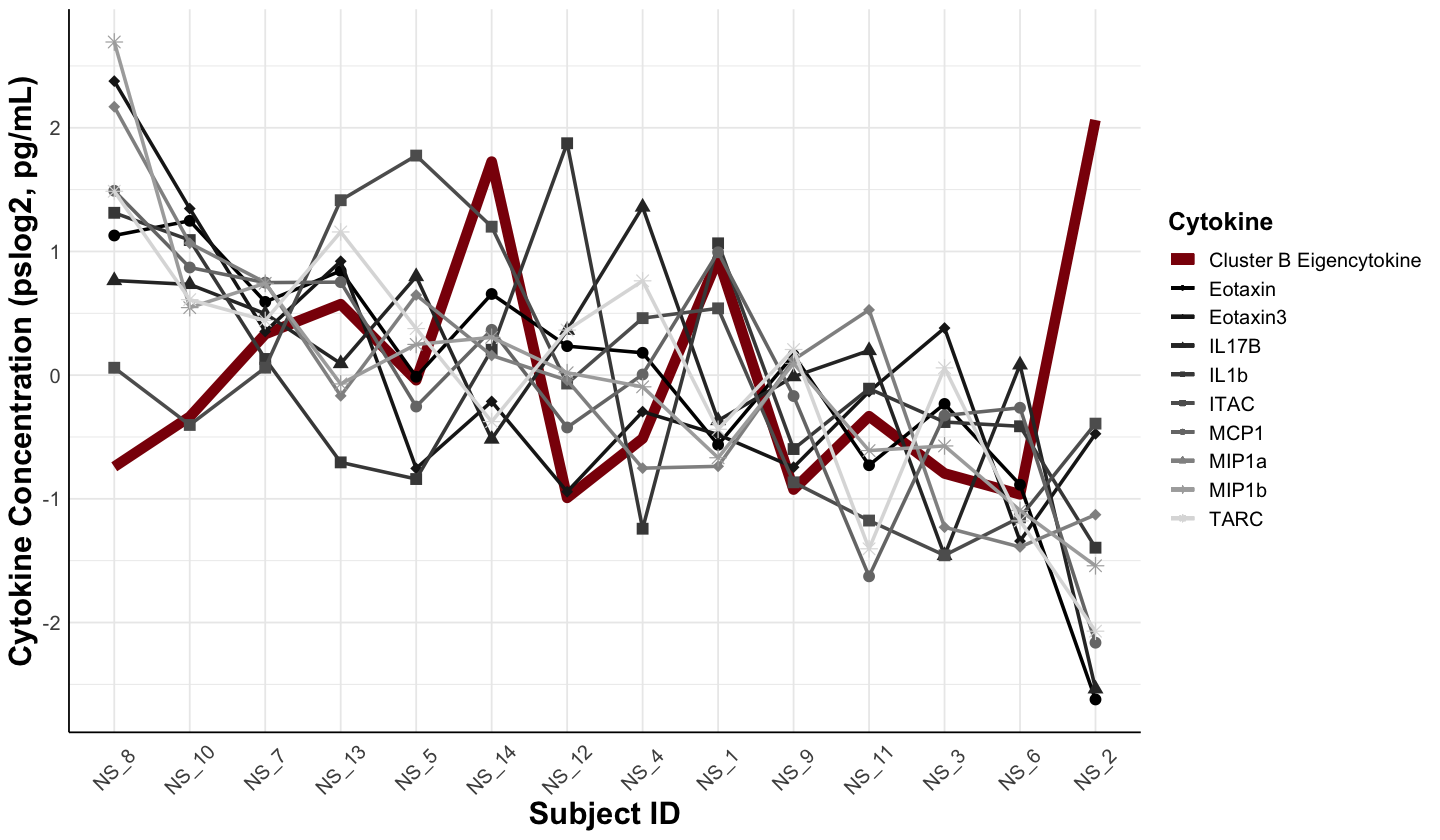

In [9]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
subject_ids = factor(NLF_df$SubjectID, levels = descending_subject_ids_ClusterB) #need to put descending_cytokines into a factor for plotting 
Figure4_B = ggplot(data = NLF_df, aes(x = subject_ids, y = value, color = variable, group = 1)) + 
  geom_line(aes(y = ClusterB, col = "Cluster B Eigencytokine"), size = 3) + 
  geom_line(aes(y = Eotaxin, col = "Eotaxin"), size = 1) + 
  geom_point(aes(y = Eotaxin, col = "Eotaxin"), shape = 16, size = 3) +
  geom_line(aes(y = Eotaxin3, col = "Eotaxin3"), size = 1) + 
  geom_point(aes(y = Eotaxin3, col = "Eotaxin3"), shape = 18, size = 3) +
  geom_line(aes(y = IL17B, col = "IL17B"), size = 1) + 
  geom_point(aes(y = IL17B, col = "IL17B"), shape = 17, size = 3) +
  geom_line(aes(y = IL1b, col = "IL1b"), size = 1) + 
  geom_point(aes(y = IL1b, col = "IL1b"), shape = 15, size = 3) +
  geom_line(aes(y = ITAC, col = "ITAC"), size = 1) + 
  geom_point(aes(y = ITAC, col = "ITAC"), shape = 15, size = 3) +
  geom_line(aes(y = MCP1, col = "MCP1"), size = 1) + 
  geom_point(aes(y = MCP1, col = "MCP1"), shape = 16, size = 3) +
  geom_line(aes(y = MIP1a, col = "MIP1a"), size = 1) + 
  geom_point(aes(y = MIP1a, col = "MIP1a"), shape = 18, size = 3) +
  geom_line(aes(y = MIP1b, col = "MIP1b"), size = 1) + 
  geom_point(aes(y = MIP1b, col = "MIP1b"), shape = 8, size = 3) +
  geom_line(aes(y = TARC, col = "TARC"), size = 1) + 
  geom_point(aes(y = TARC, col = "TARC"), shape = 8, size = 3) +

  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12)) + #changes legend text 

  xlab('Subject ID') + ylab('Cytokine Concentration (pslog2, pg/mL)') + 
  scale_color_manual(values = c('#8b0e09', '#000000', '#1b1b1b', '#303030', '#474747', '#5e5e5e', '#777777', 
                                '#919191', '#ababab', '#dcdcdc'),
                     guide = guide_legend(title = 'Cytokine', override.aes = list(shape = c(NA,16,18,17,15,0,1,2,3,8), 
                                                                                   size = c(3,1,1,1,1,1,1,1,1,1))))
Figure4_B

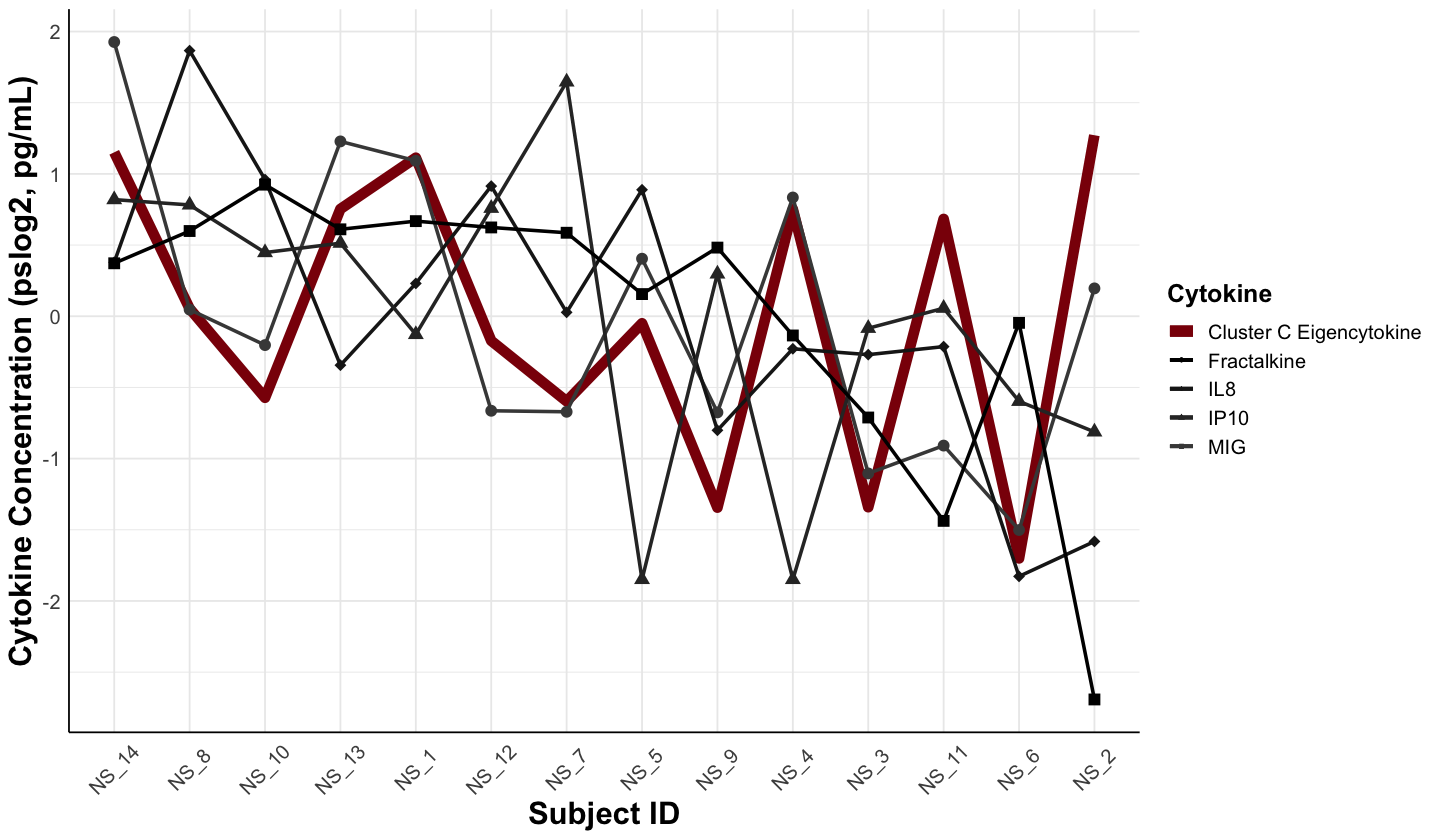

In [10]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
subject_ids = factor(NLF_df$SubjectID, levels = descending_subject_ids_ClusterC) #need to put descending_cytokines into a factor for plotting 
Figure4_C = ggplot(data = NLF_df, aes(x = subject_ids, y = value, color = variable, group = 1)) + 
  geom_line(aes(y = ClusterC, col = "Cluster C Eigencytokine"), size = 3) + 
  geom_line(aes(y = MIG, col = "MIG"), size = 1) + 
  geom_point(aes(y = MIG, col = "MIG"), shape = 16, size = 3) +
  geom_line(aes(y = IL8, col = "IL8"), size = 1) + 
  geom_point(aes(y = IL8, col = "IL8"), shape = 18, size = 3) +
  geom_line(aes(y = IP10, col = "IP10"), size = 1) + 
  geom_point(aes(y = IP10, col = "IP10"), shape = 17, size = 3) +
  geom_line(aes(y = Fractalkine, col = "Fractalkine"), size = 1) + 
  geom_point(aes(y = Fractalkine, col = "Fractalkine"), shape = 15, size = 3) +

  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12)) + #changes legend text 

  xlab('Subject ID') + ylab('Cytokine Concentration (pslog2, pg/mL)') + 
  scale_color_manual(values = c('#8b0e09', '#000000', '#1b1b1b', '#303030', '#474747'),
                     guide = guide_legend(title = 'Cytokine', override.aes = list(shape = c(NA,16,18,17,15), 
                                                                                   size = c(3,1,1,1,1))))
Figure4_C

In [9]:
ggsave(Figure4_A, 
       filename = 'Figure4.pdf',
       path = Output,
       width = 12, height = 7)